# Определение стоимости автомобилей

Необходимо разработать сервис для предсказания рыночной стоимости своего автомобиля, а именно построить модель МО для предсказания цена. 

Имеются данные о технических характеристиках, комплектации и ценах различных автомобилей.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install scikit-learn --upgrade

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from time import time
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(10,7)})

### Выгрузка данных

In [3]:
df = pd.read_csv('/datasets/autos.csv')

df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Предобработка данных

In [5]:
# посмотрим на дубликаты
df.duplicated().sum()

4

Дубликаты есть, но немного - допустим, что это разные автомобили с одинаковыми признаками.

In [6]:
# посмотрим на пропуски
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Пропуски присутствуют, обработаем их.

В столбце VehicleType проспусков много - около 10% от всех данных. Удалить не получиться, так как потеряем много нужной информации. Заменил на значение "unknown".

In [7]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')

В столбце с типом коробки передач пропуски заменим на 'unknown'.

In [8]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')

Модель машины, к сожалению, восстановить нельзя, но пропуски также не оставить - попробуем заменить заглушкой.

In [9]:
df['Model'] = df['Model'].fillna('unknown')

Пропуски в FuelType заменим также заглушкой.

In [10]:
df['FuelType'] = df['FuelType'].fillna('unknown')

В столбце Repaired пропуски заменим также на unknown.

In [11]:
df['Repaired'].fillna('unknown')

0         unknown
1             yes
2         unknown
3              no
4              no
           ...   
354364        yes
354365    unknown
354366         no
354367         no
354368    unknown
Name: Repaired, Length: 354369, dtype: object

In [12]:
# посмотрим на неявные дубликаты в столбцах brand, fuel type, gearbox
for i in df[['Brand', 'FuelType', 'Gearbox']]:
        print(f'Уникальные значение в столбце "{i}": {df[i].unique()}')
        print('\n')

Уникальные значение в столбце "Brand": ['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']


Уникальные значение в столбце "FuelType": ['petrol' 'gasoline' 'unknown' 'lpg' 'other' 'hybrid' 'cng' 'electric']


Уникальные значение в столбце "Gearbox": ['manual' 'auto' 'unknown']




Неявных дублей тоже не обнаружено.

In [13]:
# проведем исследовательский анализ
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


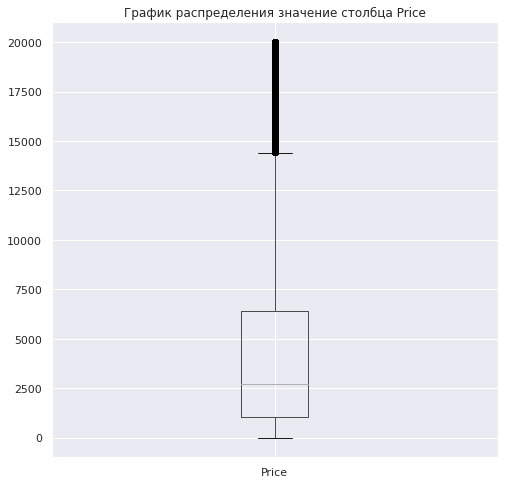

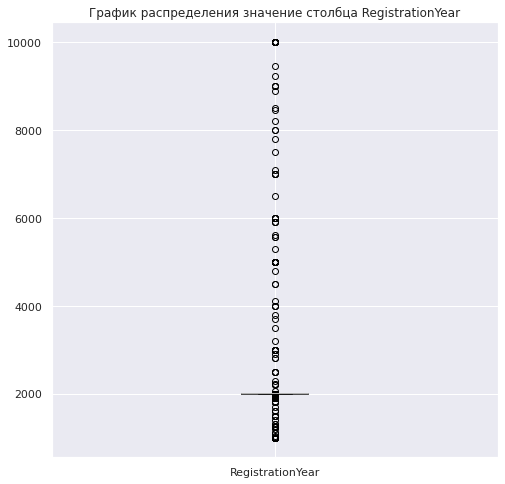

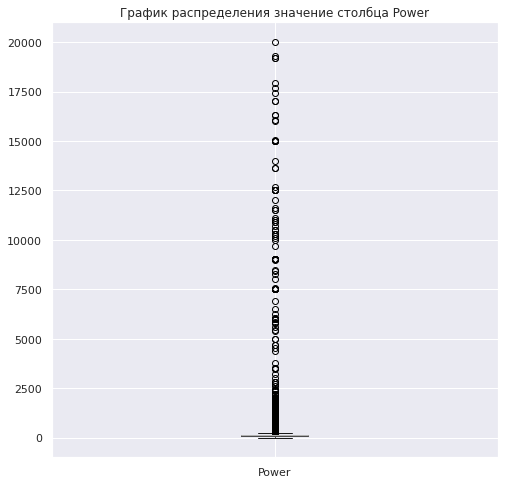

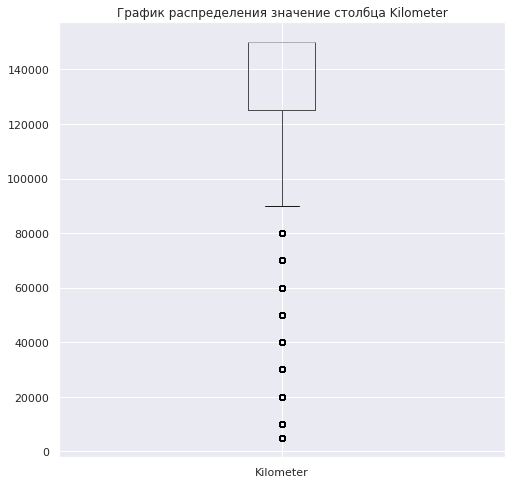

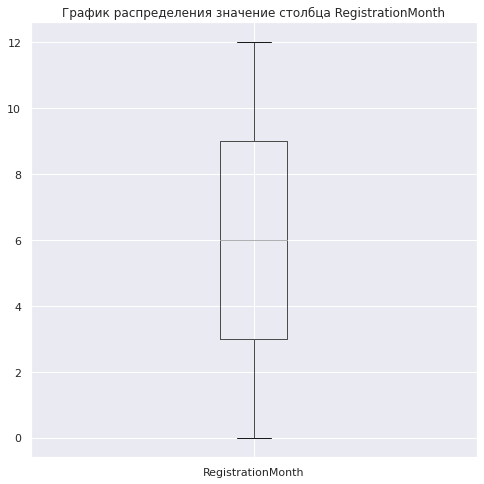

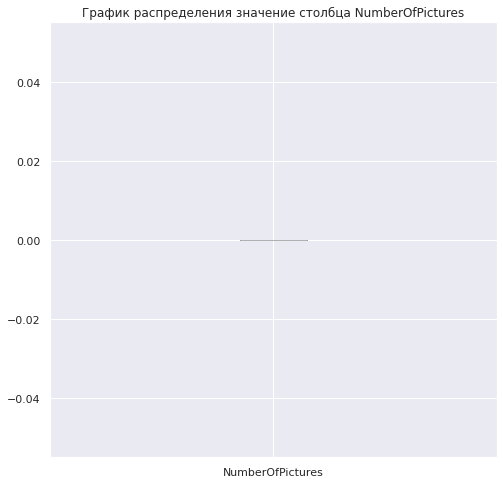

In [14]:
# построим ящик с усами
for i in df[['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures']]:
        df.boxplot(column=i, figsize=(8,8))
        plt.title(f'График распределения значение столбца {i}')
        plt.show()

Практические везде присутствуют аномальные значение.
Нам следует:
- Исключить данные, где стоимость автомобиля менее 500 евро (если цена меньше, то, скорее всего, это ошибка).
- Исключить данные, где год регистрации больше 2016 и меньше 1960.
- Исключить авто с мощностью более 1600 л/с и менее 50 л/с.


Признаки NumberOfPictures, PostalCode, DateCrawled, LastSeen, DateCreated, RegistrationMonth не несут полезной информации, их можно удалить.

In [15]:
df = df.query('Price > 500 and RegistrationYear > 1950 and RegistrationYear < 2017 and Power < 1600 and Power > 50') \
.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'LastSeen', 'DateCreated', 'RegistrationMonth'], axis=1)

In [16]:
# посмотрим еще раз на наличие явных дублей
df.duplicated().sum()

35450

In [17]:
# удалим дубли
df = df.drop_duplicates()

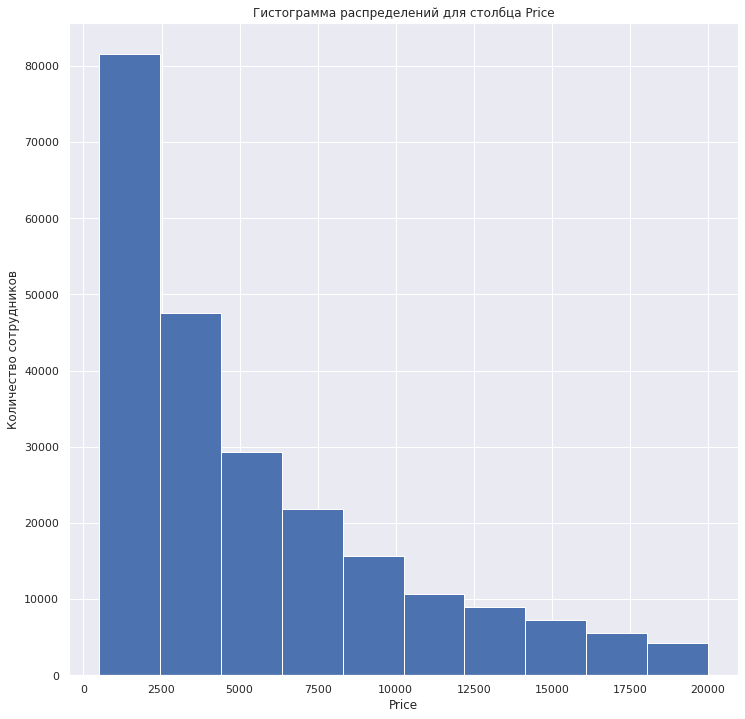

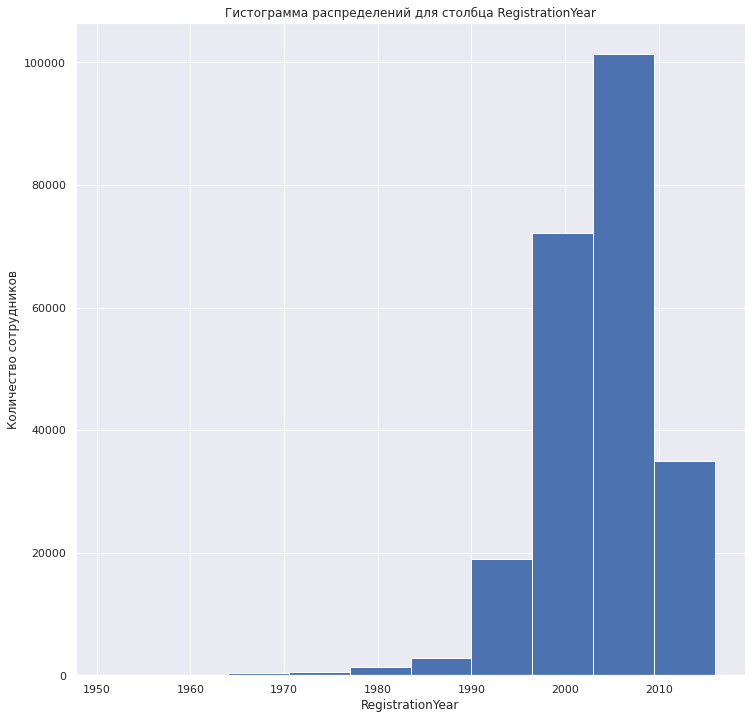

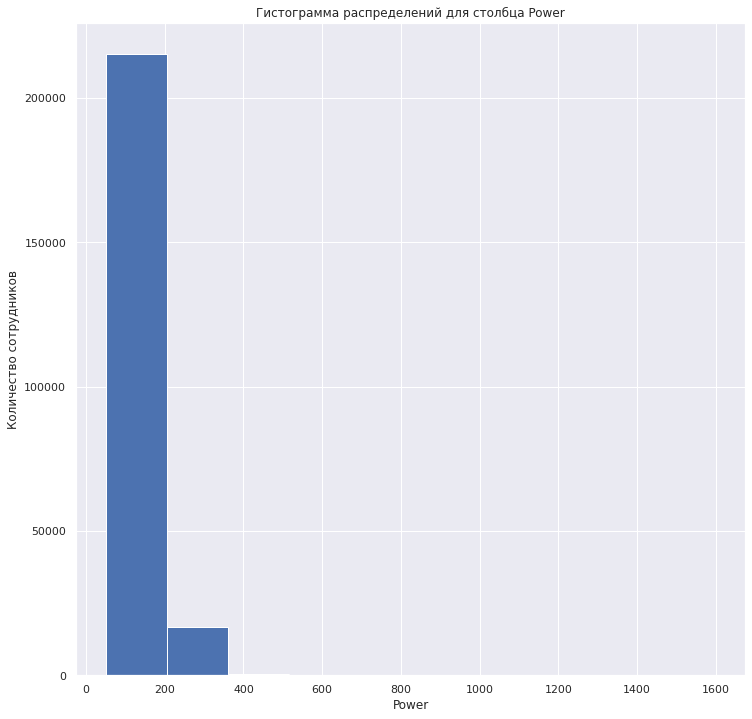

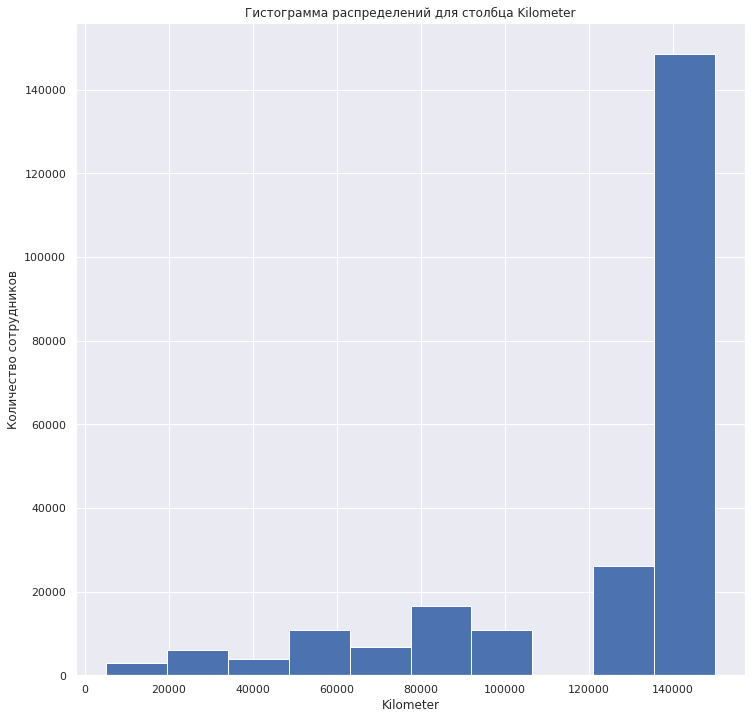

In [18]:
# построим гистограммы
for i in df[['Price', 'RegistrationYear', 'Power', 'Kilometer']]:
            fig, ax = plt.subplots(figsize=(12, 12))
            plt.hist(df[i])
            plt.title(f'Гистограмма распределений для столбца {i}')
            plt.xlabel(f'{i}')
            plt.ylabel('Количество сотрудников')
            plt.show()

Большинство данных имеют ненормальное распределение.

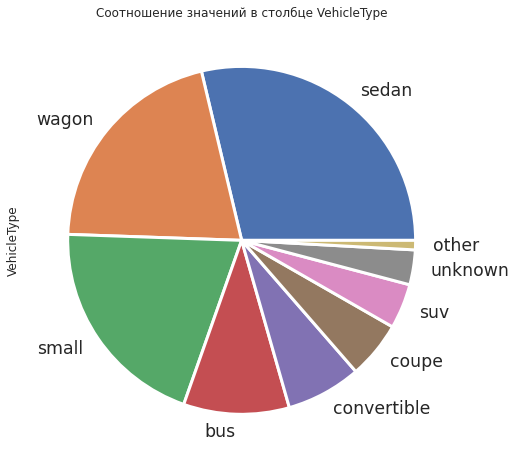

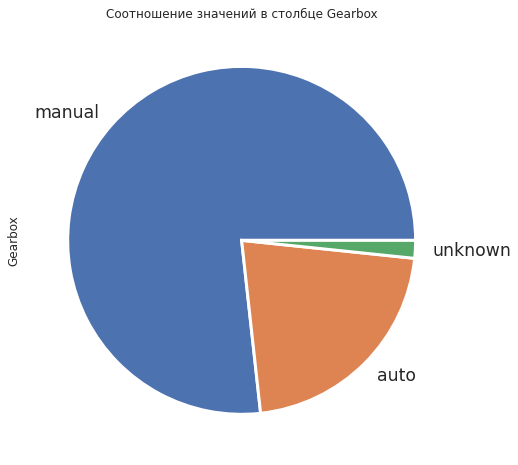

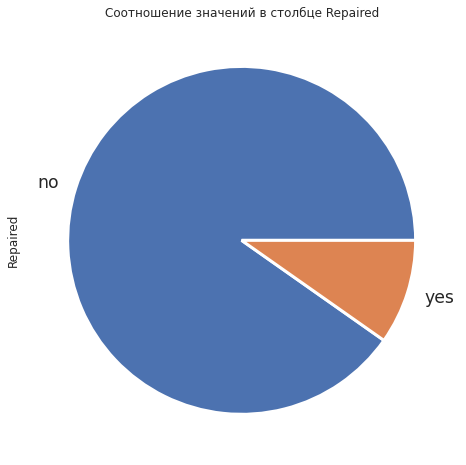

In [19]:
# построим диаграммы для некоторых качественных переменных
for i in df[['VehicleType', 'Gearbox', 'Repaired']]:
        df[i].value_counts(normalize=True).plot(
            kind='pie', 
            figsize=(8, 8),
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            textprops={'size': 'x-large'}, 
            legend=False,)
        plt.title(f'Соотношение значений в столбце {i}')
        plt.show()

Большинство автомобилей:
- имеют тип кузова small, sedan или wagon
- имеют МКПП
- не были в ремонте

### Вывод
- Произвелась выгрузка данных
- Данные были проверены на дубликаты
- По возможности данные с пропусками были восстановлены, остальные - удалены.

## Обучение моделей

### Подготовка данных

In [20]:
RANDOM_STATE = 74

In [21]:
# выделим категориальные признаки
cat_cols = ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType', 
            'Repaired', 'Kilometer', 'RegistrationYear']

# определим количественные признаки
num_cols = ['Power']

In [22]:
# разделим признаки на выходные и целевой
X = df.drop('Price', axis= 1)
y = df['Price']

In [23]:
# разделим данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.25)

In [24]:
# категориальные признаки закодируем при помощи OrdinalEncoder
# чтобы не размножать много признаков
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)

In [25]:
# кодируем качественные признаки
X_train_ord = encoder.fit_transform(X_train[cat_cols])
X_test_ord = encoder.transform(X_test[cat_cols])

X_train_ord = pd.DataFrame(X_train_ord, columns=cat_cols)
X_test_ord = pd.DataFrame(X_test_ord, columns=cat_cols)

In [26]:
# масштабируем количественные признаки
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols)

In [27]:
# создадим окончательные выборки
X_train = pd.concat([X_train_ord, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ord, X_test_scaled], axis=1)

### DecisionTreeRegressor

In [28]:
param_dtr = {"splitter":["best","random"],
                  "max_depth" :range(1, 12),
                  "min_samples_leaf":range(1,12)}

In [29]:
dtr_model = DecisionTreeRegressor(random_state=RANDOM_STATE) 

In [30]:
rs_dtr = RandomizedSearchCV(
         dtr_model,
         param_dtr,
         scoring='neg_root_mean_squared_error') 

In [31]:
rs_dtr.fit(X_train, y_train)

RandomizedSearchCV(estimator=DecisionTreeRegressor(random_state=74),
                   param_distributions={'max_depth': range(1, 12),
                                        'min_samples_leaf': range(1, 12),
                                        'splitter': ['best', 'random']},
                   scoring='neg_root_mean_squared_error')

In [32]:
mse_dtr_model = -(rs_dtr.best_score_) #замеряем RMSE на  кросс-валидации

In [33]:
# засекаем время обучения
start = time()

In [34]:
dtr_model = rs_dtr.best_estimator_

In [35]:
dtr_model.fit(X_train, y_train) #замеряем время обучения

DecisionTreeRegressor(max_depth=7, min_samples_leaf=4, random_state=74)

In [36]:
end = time()

dtr_model_time_fit = (end-start)/60 

In [37]:
# засекаем время предсказания
start = time()

In [38]:
dtr_model.predict(X_train) #замеряем время предсказания

array([9931.6921944 , 8626.17201166, 3381.54810436, ..., 6143.18851508,
       1935.96806775, 8713.46873301])

In [39]:
end = time()

dtr_model_time_pred = (end-start)/60 

In [40]:
print("RMSE для DecisionTreeRegressor модели:", round((mse_dtr_model), 2))

RMSE для DecisionTreeRegressor модели: 2237.46


### CatBoostRegressor

In [41]:
cat_model = CatBoostRegressor(learning_rate = 0.5, random_state=RANDOM_STATE, verbose=False) 

param_cat = {"iterations":range(100, 1000, 100)}

In [42]:
rs_cat = RandomizedSearchCV(
         cat_model,
         param_cat,
         scoring='neg_root_mean_squared_error') 

In [43]:
rs_cat.fit(X_train, y_train)

mse_cat_model = -(rs_cat.best_score_) #замеряем RMSE на  кросс-валидации

In [44]:
# засекаем время обучения
start = time()

In [45]:
cat_model = rs_cat.best_estimator_

In [46]:
cat_model.fit(X_train, y_train) #замеряем время обучения

In [47]:
end = time()

cat_model_time_fit = (end-start)/60 

In [48]:
# засекаем время предсказания
start = time()

In [49]:
cat_model.predict(X_train) #замеряем время предсказания

array([9735.01333759, 8903.98555121, 2964.06196468, ..., 4979.68546365,
        792.97380076, 8191.1089013 ])

In [50]:
end = time()

cat_model_time_pred = (end-start)/60 

In [51]:
print("RMSE для CatBoostRegressor модели:", round((mse_cat_model), 2))

RMSE для CatBoostRegressor модели: 1612.79


### LightGBM Regressor

In [52]:
lgbm_model = LGBMRegressor(learning_rate=0.1, 
                           random_state=RANDOM_STATE)

param_lgbm = {"num_leaves":range(100, 1000, 100),
              "max_depth" :range(1, 12)}

In [53]:
rs_lgbm = RandomizedSearchCV(
          lgbm_model,
          param_lgbm,
          scoring='neg_root_mean_squared_error') 

In [54]:
rs_lgbm.fit(X_train, y_train)

mse_lgbm_model = -(rs_lgbm.best_score_) #замеряем RMSE на  кросс-валидации

In [55]:
# засекаем время обучения
start = time()

In [56]:
lgbm_model = rs_lgbm.best_estimator_

In [57]:
lgbm_model.fit(X_train, y_train) #замеряем время обучения

LGBMRegressor(max_depth=10, num_leaves=300, random_state=74)

In [58]:
end = time()

lgbm_model_time_fit = (end-start)/60 

In [59]:
# засекаем время предсказания
start = time()

In [60]:
lgbm_model.predict(X_train) #замеряем время предсказания

array([10654.01417469,  8659.06256198,  2907.93072034, ...,
        4869.90044717,   740.58920708,  8331.35541518])

In [61]:
end = time()

lgbm_model_time_pred = (end-start)/60 

In [62]:
print("RMSE для CatBoostRegressor модели:", round((mse_lgbm_model), 2))

RMSE для CatBoostRegressor модели: 1614.97


### Вывод
- Были обучены модели и сделаны предсказани с замером времени каждого шага.
- Следующий шаг - анализ полученных результатов и проверка лучшей модели на тестовой выборке.

## Анализ моделей

In [63]:
res = [[round((mse_dtr_model), 2), dtr_model_time_fit, dtr_model_time_pred],
      [round((mse_cat_model), 2), cat_model_time_fit, cat_model_time_pred],
      [round((mse_lgbm_model), 2), lgbm_model_time_fit, lgbm_model_time_pred]]
model = ["DecisionTreeRegressor", "CatBoostRegressor", "LightGBMRegressor"]

In [64]:
results = pd.DataFrame(data=res, index=model, columns=[ "RMSE", "fit_time", "predict_time"])

results

,RMSE,fit_time,predict_time
DecisionTreeRegressor,2237.46,0.007421,0.001404
CatBoostRegressor,1612.79,0.314135,0.002461
LightGBMRegressor,1614.97,0.264827,0.034847


- Самое быстро время обучения и предсказания - у DecisionTreeRegressor.
- Самая лучшая метрика и время обучения у LightGBM.
- Думаю, что лучшей моделью является CatBoostRegressor - метрика на уровне с LGBM, но время предсказания значительно меньше. В, целом, обучаться модель будет один раз, поэтому предпочтения можно отдать CatBoost, а не DecisionTreeRegressor.

In [65]:
# проверим метрику CatBoost на тестовой выборке
pred_cat = rs_cat.best_estimator_.predict(X_test)
print(f'RMSE на тестовой выборке для CatBoostRegressor: {round(mean_squared_error(y_test, pred_cat)** 0.5)}')

RMSE на тестовой выборке для CatBoostRegressor: 1602


- Модель также себя показала отлично и на тестовой выборке.

### Проверка на адекватность

In [66]:
# инициируем модель, предсказывающий константное значение
# в качестве этого значения возьмем среднее
model = DummyRegressor(strategy="mean")

In [67]:
model.fit(X_train, y_train)

pred_dummy = model.predict(X_test)

mse_dummy_model = mean_squared_error(y_test, pred_dummy)

print("RMSE для Dummy модели:", round((mse_dummy_model) ** 0.5, 2))

RMSE для Dummy модели: 4663.9


Видно, что метрика на выбранной нами модели намного лучше. Тест на адекватность пройден.

## Заключение
- Были обучены модели, после чего был произведен анализ скорости обучения, предсказания и метрики RMSE.
- Выбрана лучшая модель - CatBoostRegressor.
- Модель проверена на адекватность.